In [11]:
# Parameters
start_range = 0.4
end_range = 10

number_of_shape_countours_threshold = 150

center_x_adjustment = 0
center_y_adjustement = -3
ellipse_x_adjustment = -35
ellipse_y_adjustment = -35

start_gauge_angle = 217
end_gauge_angle = -45

threshold_value = 90
threshold_brightness = 255
minLineLength = 40
maxLineGap = 1

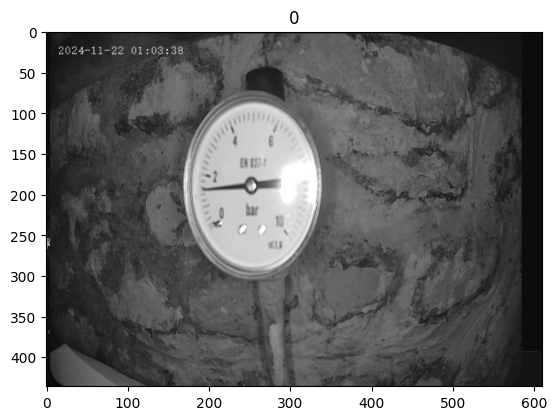

In [12]:
from matplotlib import pyplot as plt
import cv2
import glob

# List all images with name image{X}.png
image_files = glob.glob('image_*_main.png')

# Load all images using cv2
images = [cv2.imread(image_file) for image_file in image_files]

for i in range(len(images)):
  plt.imshow(images[i])
  plt.title(i)
  plt.show()

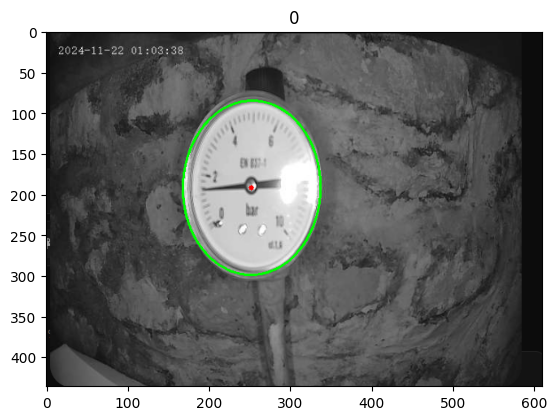

In [13]:
import numpy as np

from lib.helpers import find_ellipses

ellipses = []
for a in range(len(images)):
  image = images[a]
  ellipses.append(find_ellipses(image, number_of_shape_countours_threshold))

  ellipse_image = image.copy()

  for ellipse in ellipses[a]:
    # Draw the ellipse
    cv2.ellipse(ellipse_image, ellipse, (0, 255, 0), 2)

    # Draw the center of the ellipse
    center = (int(ellipse[0][0]), int(ellipse[0][1]))
    cv2.circle(ellipse_image, center, 3, (255, 0, 0), -1)

  # Display the output image with ellipses drawn
  plt.imshow(ellipse_image)
  plt.title(i)
  plt.show()


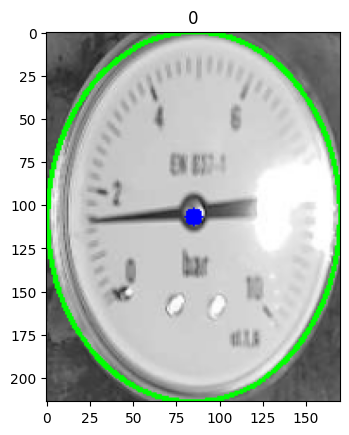

In [14]:
cropped_images = []
cropped_params = []

import lib.helpers as helpers


for a in range(len(images)):
  cropped_images.append([])
  cropped_params.append([])

  for i in range(len(ellipses[a])):
    ellipse = ellipses[a][i]
    cropped_image, new_ellipse, crop_params = helpers.crop_image_to_ellipsis(ellipse, images[a])

    cropped_images[a].append(cropped_image)
    cropped_params[a].append(crop_params)
    ellipses[a][i] = new_ellipse

    # Create a copy of the cropped image to draw the new ellipse on
    cropped_image_with_ellipse = cropped_image.copy()

    # Draw the new ellipse
    cv2.ellipse(cropped_image_with_ellipse, new_ellipse, (0, 255, 0), 2)

    # Draw the center of the new ellipse
    cv2.circle(cropped_image_with_ellipse, (int(new_ellipse[0][0]), int(new_ellipse[0][1])), 5, (0, 0, 255), -1)

    # Display the cropped image with the new ellipse and center
    plt.imshow(cropped_image_with_ellipse)
    plt.title(i)
    plt.show()

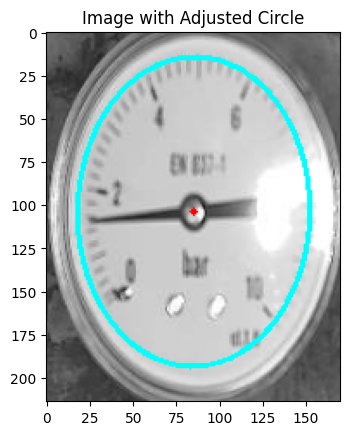

In [15]:
# Adjust the radius
for a in range(len(images)):
  for i in range(len(ellipses[a])):
    ellipse = ellipses[a][i]
    x, y = ellipse[i]
    adjusted_center = (int(x + center_x_adjustment), int(y + center_y_adjustement))
    adjusted_ellipsis = (adjusted_center, (ellipse[1][0] + ellipse_x_adjustment, ellipse[1][1] + ellipse_x_adjustment), ellipse[2])

    ellipses[a][i] = adjusted_ellipsis

    # Create a copy of the original image to draw the adjusted circle on
    adjusted_circle_image = cropped_images[a][i].copy()

    # Draw the center of the adjusted circle
    cv2.circle(adjusted_circle_image, adjusted_center, 2, (255, 0, 0), -1)

    # Draw the ellipse using the adjusted radius and center
    cv2.ellipse(adjusted_circle_image, adjusted_ellipsis, (0, 255, 255), 2)

    # Display the image with the adjusted circle
    plt.imshow(adjusted_circle_image)
    plt.title('Image with Adjusted Circle')
    plt.show()


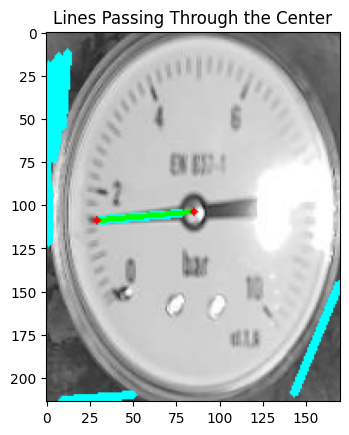

In [16]:

import lib.helpers as helpers

needle_points = []
for a in range(len(images)):
  needle_points.append([])
  for i in range(len(ellipses[a])):
    ellipse = ellipses[a][i]
    needle_point, filtered_lines, all = helpers.find_needle(cropped_images[a][i], ellipse, threshold_value, threshold_brightness, minLineLength, maxLineGap)

    if needle_point is None:
      needle_points[a].append(None)
      print('No needle found')
      continue

    needle_points[a].append(needle_point)

    render_needle = cropped_images[a][i].copy()

    # Draw all the filtered lines on the ROI
    for line in all:
      x1, y1, x2, y2 = line[0]
      cv2.line(render_needle, (x1, y1), (x2, y2), (128, 0, 0), 1)

    # Draw all the filtered lines on the ROI
    for line in filtered_lines:
      x1, y1, x2, y2 = line[0]
      cv2.line(render_needle, (x1, y1), (x2, y2), (255, 255, 0), 3)

    # Draw the lines on the ROI
    cv2.line(render_needle, needle_point, ellipses[a][i][0], (0, 255, 0), 2)

    # Draw the furthest point on the ROI
    cv2.circle(render_needle, needle_point, 2, (0, 0, 255), -1)

    # Draw the center of the ROI
    cv2.circle(render_needle, ellipses[a][i][0], 2, (0, 0, 255), -1)

    # Display the image with lines
    plt.imshow(cv2.cvtColor(render_needle, cv2.COLOR_BGR2RGB))
    plt.title('Lines Passing Through the Center')
    plt.show()

Files matching pattern 'image_cave_*.png': ['image_cave_1.png', 'image_cave_main.png']
Value 1.669678109542314


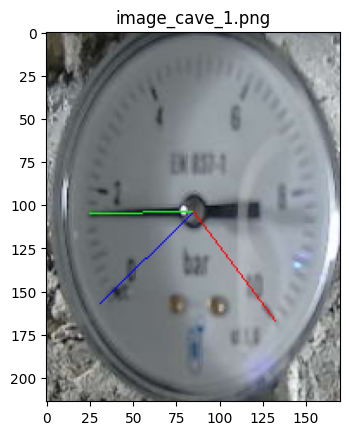

Value 1.5652959923273997


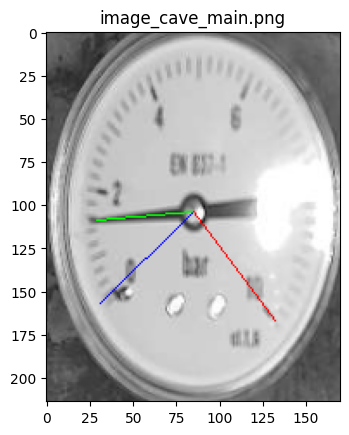

In [21]:
import re

# Extract the type part from the file name
type_pattern = re.compile(r'image_(.*?)_main\.png')
types = [type_pattern.search(file).group(1) for file in image_files]

# Look for files matching the pattern "image_{type}_{x}.png"
for a in range(len(images)):
  pattern = f'image_{types[a]}_*.png'
  matching_files = glob.glob(pattern)
  
  print(f"Files matching pattern '{pattern}': {matching_files}")

  # Load each matching image using cv2
  for file in matching_files:
    image = cv2.imread(file)

    for i in range(len(ellipses[a])):
      (top_left_x, top_left_y, bottom_right_x, bottom_right_y) = cropped_params[a][i]

      cropped = image[top_left_y:bottom_right_y, top_left_x:bottom_right_x].copy()

      needle, filtered, all = helpers.find_needle(cropped, ellipses[a][i], threshold_value, threshold_brightness, minLineLength, maxLineGap)

      # # Draw all the filtered lines on the ROI
      # for line in all:
      #   x1, y1, x2, y2 = line[0]
      #   cv2.line(cropped, (x1, y1), (x2, y2), (128, 0, 0), 1)

      # # Draw all the filtered lines on the ROI
      # for line in filtered_lines:
      #   x1, y1, x2, y2 = line[0]
      #   cv2.line(cropped, (x1, y1), (x2, y2), (255, 255, 255), 1)

      if not needle is None:
        gauge_value = helpers.calculate_gauge_value(ellipse, needle, start_gauge_angle, end_gauge_angle, start_range, end_range)

        print("Value", gauge_value)

        # Draw the needle on the cropped image
        cv2.line(cropped, needle, ellipses[a][i][0], (0, 255, 0), 1)
      else:
        print("No needle found")

      center = ellipse[0]

      radius_x = ellipse[1][0] / 2
      radius_y = ellipse[1][1] / 2
      start_angle_rad = np.deg2rad(start_gauge_angle)
      end_angle_rad = np.deg2rad(end_gauge_angle)

      start_point = (int(center[0] + radius_x * np.cos(start_angle_rad) ),
              int(center[1] - radius_y * np.sin(start_angle_rad)))
      end_point = (int(center[0] + radius_x * np.cos(end_angle_rad)),
            int(center[1] - radius_y * np.sin(end_angle_rad)))

       # Draw the start gauge limit
      cv2.line(cropped, center, start_point, (255, 0, 0), 1)

      # Draw the end gauge limit
      cv2.line(cropped, center, end_point, (0, 0, 255), 1)

      plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
      plt.title(file)
      plt.show()

